# Notes

Main results:
1. Cell type classification
    - Should scale this up by demonstrating across datasets/batches for a more notable result

2. Cell type marker calculation
    - Not super unique though. How can we leverage separate output-specific weights? (segue)

3. Hierarchical marker calculation
    - Opportunity for hierarchical understanding?

4. Dimension reduction
    - Reconstructs PC space (altho not surprising since it was trained on K-means from top PCs in the first place)
    - But also does so for the hierarchical case, which is much cooler

# Imports

In [1]:
import scanpy as sc
import numpy as np
import plotly.express as px
import pandas as pd
import einops
import torch

from scripts.datasets import myeloid_classes
from scripts.bmlp import ScBMLPClassifier, Config

# Set params

In [3]:
DEVICE = "cpu"  # faster than mps...

# Load data

In [4]:
adata, train_dataset, val_dataset, test_dataset = myeloid_classes(device=DEVICE, n_cell_types=3, class_key="cell_type")

In [5]:
n_cells, n_genes = adata.shape
n_cell_types = adata.obs["cell_type"].nunique()

## Visualize

In [6]:
fig = px.scatter(
    x=adata.obsm["X_pca"][:, 0],
    y=adata.obsm["X_pca"][:, 1],
    color=adata.obs["cell_type"],
    title="Myeloid progenitor differentiation data",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

# Train model

In [43]:
d_hidden = 64
n_epochs = 100
lr = 1e-5

In [44]:
cfg = Config(
    d_input=n_genes,
    d_hidden=d_hidden,
    d_output=n_cell_types,
    n_epochs=n_epochs,
    lr=lr,
    device=DEVICE,
)
model = ScBMLPClassifier(cfg)
train_losses, val_losses = model.fit(train_dataset, val_dataset)

Training for 100 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training for 100 epochs: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s, train_acc=1.0000, train_loss=0.0066, val_acc=0.8949, val_loss=0.2756]


In [45]:
# Combine train and val losses into a single plot
loss_df = pd.DataFrame({
    'Epoch': list(range(len(train_losses))) + list(range(len(val_losses))),
    'Loss': train_losses + val_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)
})

px.line(loss_df, x='Epoch', y='Loss', color='Type', 
        title='Training and Validation Loss', 
        labels={'Loss': 'Loss', 'Epoch': 'Epoch'}).show()

# Interpret weights

## Investigate a particular $Q$ matrix (cell type)

In [9]:
cell_type = 0

In [10]:
q = einops.einsum(model.w_p[cell_type], model.w_l, model.w_r, "hid, hid in1, hid in2 -> in1 in2")
q = 0.5 * (q + q.mT)  # symmetrize

In [11]:
# px.imshow(
#     q,
#     color_continuous_scale='RdBu_r',
#     color_continuous_midpoint=0,
# )

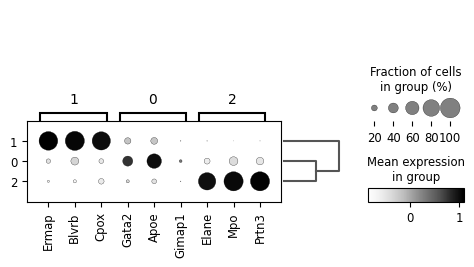

In [12]:
# Calculate gene markers for reference
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="logreg", n_genes=adata.shape[1])
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

In [13]:
vals, vecs = torch.linalg.eigh(q)
vals = vals.flip([0])
vecs = vecs.flip([1])

In [14]:
px.histogram(vals.flatten(), nbins=100, title="Eigenvalues of $Q$").show()

In [15]:
n_top_genes = 10
for i in range(3):  # top components
    top_idxs = vecs[:,i].topk(n_top_genes).indices
    top_genes = adata.var_names[top_idxs].tolist()
    bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
    bottom_genes = adata.var_names[bottom_idxs].tolist()
    print("="*20, f"Component {i} ({vals[i]})", "="*20)
    print(top_genes)
    print(bottom_genes)

==================== Component 0 (0.08624430000782013) ====================
['Ccne1', 'Hp', 'Sphk1', '1190002H23Rik', 'Phb2', 'Pla2g12a', 'Mfhas1', 'Isyna1', 'Hba-a2', 'Asns']
['Apoe', 'Nrgn', 'Gata2', 'Serpina3f', 'Ptprcap', 'Gpr56', 'Zyx', 'Akap13', 'S100a10', 'F2r']
==================== Component 1 (0.02617865987122059) ====================
['Csk', 'Psmg2', 'Peo1', 'Npl', 'Ndufv2', 'Abca3', 'Phf21a', 'Mospd3', 'Nudt3', 'Urod']
['Mfsd6', 'Gata2', 'AK081796', 'Kif15', 'Fam129a', 'Dock10', '5830432E09Rik', 'Fasn', 'Atp5f1', 'Atp1b3']
==================== Component 2 (0.025213707238435745) ====================
['Rab37', 'H3f3a', 'Txnrd1', 'Tnks2', 'Wdr81', 'Rangrf', 'Hsd17b1', 'Fads3', 'Dclre1a', '2310005E10Rik']
['Serp1', 'Tmem229b', 'Ccdc102a', 'Fxyd5', 'Bcl9', 'Rab11fip1', 'Fbxo9', 'Nudt9', 'Ftl1', 'Iars2']


In [16]:
# n_top_genes = 10
# for c in range(n_cell_types):
#     print(f"Cell type {c}")
#     for i in range(n_genes-1, n_genes-4, -1):  # top components
#         top_idxs = vecs[:,i].topk(n_top_genes).indices
#         top_genes = adata.var_names[top_idxs].tolist()
#         bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
#         bottom_genes = adata.var_names[bottom_idxs].tolist()
#         print("="*20, f"Component {i} ({vals[i]})", "="*20)
#         print(top_genes)
#         print(bottom_genes)
#     print()

Bottom components don't look that interesting.

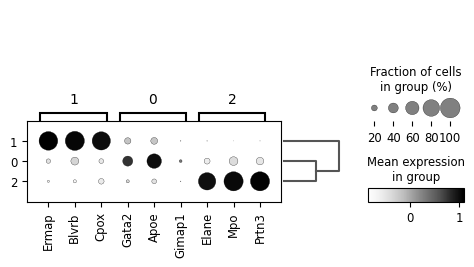

In [17]:
# Plot again for reference
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

### Plot cells in $Q$ component space

In [18]:
adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

fig = px.scatter(
    x=adata.obsm["X_Q"][:, 0],
    y=adata.obsm["X_Q"][:, 1],
    color=adata.obs["cell_type"],
    title="Myeloid progenitor differentiation data",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

# Iterate over output directions

In [50]:
b = einops.einsum(model.w_p, model.w_l, model.w_r, "out hid, hid in1, hid in2 -> out in1 in2")
b = 0.5 * (b + b.mT)  # symmetrize

## Print component markers

In [51]:
n_top_genes = 10
for c in range(n_cell_types):

    print(f"Cell type {c}")

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    for i in range(3):  # top components
        top_idxs = vecs[:,i].topk(n_top_genes).indices
        top_genes = adata.var_names[top_idxs].tolist()
        bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
        bottom_genes = adata.var_names[bottom_idxs].tolist()
        print("="*20, f"Component {i} ({vals[i]})", "="*20)
        print(top_genes)
        print(bottom_genes)
    print()

Cell type 0
==================== Component 0 (0.0620792880654335) ====================
['Apoe', 'Gata2', 'Ptprcap', 'Slc22a3', 'F2r', 'Dok2', 'Lat', 'Ifitm1', 'Gnb2l1', 'Pbx1']
['Fbxo10', 'Pkhd1l1', 'Cachd1', 'Lman2', 'Igf2r', 'Ccne1', 'Gsr', 'Hbb-b1', 'Hexa', '1190002H23Rik']
==================== Component 1 (0.026578856632113457) ====================
['Sec22c', 'Atp6v0b', 'Ncapd2', 'Cnpy3', 'Spin1', 'AK041647', 'Hsp90ab1', 'Ctage5', 'Atp1b3', 'Stat3']
['Elane', 'P4hb', 'Cd2', 'Dpp4', 'Slc18a2', 'Pdxk', 'Serpina3f', 'Rgs14', 'Pfkp', 'Sytl4']
==================== Component 2 (0.02629852667450905) ====================
['Angpt1', 'C230096C10Rik', 'Egln3', 'Ccnd1', 'Dnhd1', 'Uhrf1bp1', 'Eif2d', 'Khdrbs1', 'Srprb', 'Nfic']
['Ffar2', 'Myadm', 'Mllt3', 'Mipol1', 'Tcfe3', 'Kdm2a', 'Icam2', 'Ak3', 'Akap13', 'Med30']

Cell type 1
==================== Component 0 (0.046267516911029816) ====================
['Vim', 'Limd2', 'Ifitm1', 'Mpo', 'Slc44a2', 'Ptgr1', 'Gpc1', 'Fes', 'Tifab', 'Emb']
['Mth

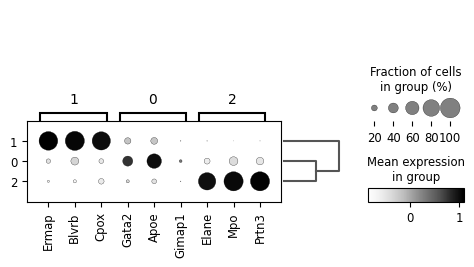

In [52]:
# Plot again for reference
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, cmap="Greys")

But marker genes are grouped on one side of a component.
- What does the other side mean?
- Explore analytically.

## Plot cells in component space

In [53]:
for c in range(n_cell_types):

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

    fig = px.scatter(
        x=adata.obsm["X_Q"][:, 0],
        y=adata.obsm["X_Q"][:, 1],
        color=adata.obs["cell_type"],
        title=f"Cell type {c}",
        width=600,
        height=600,
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

Looks like the first component nicely separates the cells in the given type from the others.
- Cell type 0 components just happen to separate all three types radially quite nicely?

Could also just plot type histograms if only the top component is important.

In [54]:
for c in range(n_cell_types):

    vals, vecs = torch.linalg.eigh(b[c])
    vals = vals.flip([0])
    vecs = vecs.flip([1])

    adata.obsm["X_Q"] = adata.X @ vecs[:, :3].numpy()  # project into component space

    hist_df = pd.DataFrame({
        "component": adata.obsm["X_Q"][:, 0],
        "cell_type": adata.obs["cell_type"]
    })
    
    fig = px.histogram(
        hist_df,
        x="component",
        color="cell_type",
        title=f"Cell type {c} component histograms",
        opacity=0.7,
        nbins=30,
        barmode="overlay",
        width=600,
        height=300,
    )
    fig.show()

Nice, the pattern is clear in the histograms of just the top components.

What happens if we plot these cells in the space spanned by each cell type's top component?

In [55]:
top_vecs = []
for c in range(n_cell_types):
    _, vecs = torch.linalg.eigh(b[c])
    top_vecs.append(vecs[:,0])
top_vecs = torch.stack(top_vecs, dim=1)

adata.obsm["X_Q_tops"] = adata.X @ top_vecs.numpy()  # project into top component space

fig = px.scatter_3d(
    x=adata.obsm["X_Q_tops"][:, 0],
    y=adata.obsm["X_Q_tops"][:, 1],
    z=adata.obsm["X_Q_tops"][:, 2],
    color=adata.obs["cell_type"],
    title=f"Top component space",
    width=600,
    height=600,
)
fig.update_traces(marker=dict(size=5))
fig.show()

Reconstructs PC space. Could provide dimension reduction capability.

Could be trivial due to K-means' reliance on PCA.

# Phenotypic groups

In [25]:
output_dir = torch.tensor([0.,1.,1.])  # differentiated types
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")

In [26]:
vals, vecs = torch.linalg.eigh(q)
vals = vals.flip([0])
vecs = vecs.flip([1])

In [27]:
px.histogram(vals.flatten(), nbins=100, title="Eigenvalues of $Q$").show()

In [28]:
n_top_genes = 10
for i in range(3):  # top components
    top_idxs = vecs[:,i].topk(n_top_genes).indices
    top_genes = adata.var_names[top_idxs].tolist()
    bottom_idxs = (-vecs[:,i]).topk(n_top_genes).indices
    bottom_genes = adata.var_names[bottom_idxs].tolist()
    print("="*20, f"Component {i} ({vals[i]})", "="*20)
    print(top_genes)
    print(bottom_genes)

==================== Component 0 (0.0766754224896431) ====================
['Adssl1', 'Emb', 'Vim', 'Igfbp4', 'Lgals1', 'Gm14005', 'H2afy', 'Mpo', 'Fxyd5', 'Dtx4']
['Blvrb', 'Lmna', 'Pklr', 'Car2', 'Zfpm1', 'Cyth3', 'Sphk1', 'Xrcc5', 'Ell2', 'Cpox']
==================== Component 1 (0.04178326949477196) ====================
['Ncf1', 'Lpcat2', '5730528L13Rik', 'Arsb', 'Cars', 'Csgalnact2', 'Arid4b', 'Tuba8', 'Med7', 'Rab44']
['Ifnar2', 'Sell', 'Tmem109', 'Hmgb2', 'Ddx21', 'Psmb4', 'Gmip', 'Birc6', 'Mybbp1a', 'Dennd1b']
==================== Component 2 (0.03960025683045387) ====================
['Sod1', 'Ugt1a1', 'Aif1', 'Atp2a2', 'Qdpr', 'Il4ra', 'Rpl4', 'Mbd2', 'Nme4', 'Vamp2']
['Alox5', 'Tspyl3', 'Stx3', 'Timeless', 'Lrp1', 'Gata2', 'Rab27a', 'Zswim4', 'Il1r1', 'Nupr1']


Not a good demonstration because `not(0)` = `(1,2)`, so really the markers for these two matrices should be the same?

## Check for consistency btwn complimentary directions

In [29]:
# Differentiated vs undifferentiated
output_dir = torch.tensor([0.,1.,1.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_diff = vecs[:,-1]

# Undifferentiated vs differentiated
output_dir = torch.tensor([1.,0.,0.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_undiff = vecs[:,-1]

### Gene space

In [30]:
px.scatter(
    x=genes_diff,
    y=genes_undiff,
    title="Differentiated vs Undifferentiated Components (genes)",
    labels={"x": "Differentiated Component", "y": "Undifferentiated Component"},
    hover_name=adata.var_names,
    width=600,
    height=600,
)

Looks like basically no correlation. Why?

Oh but it looks like a polytope:
- Differentiated component separates the two lineage branches.
- Undifferentiated components separates un/differentiated cells.

**So when we select a subset of the output directions, the component space describes how to distinguish between them.**

### Cell space

In [31]:
cells_diff = adata.X @ genes_diff.numpy()
cells_undiff = adata.X @ genes_undiff.numpy()

In [32]:
px.scatter(
    x=cells_diff,
    y=cells_undiff,
    color=adata.obs["cell_type"],
    title="Differentiated vs Undifferentiated Components (cells)",
    labels={"x": "Differentiated Component", "y": "Undifferentiated Component"},
    width=600,
    height=600,
)

Hm, so maybe the training labels are leaking PC info in here.
- Above result could be more trivial than I'd like.

# Contrastive directions

In [46]:
output_dir = torch.tensor([1.,0.,0.])
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_zero = vecs[:,-1]

output_dir = torch.tensor([1.,-1.,-1.])  # negate other directions
q = einops.einsum(output_dir, b, "out, out in1 in2 -> in1 in2")
_, vecs = torch.linalg.eigh(q)
genes_negative = vecs[:,-1]

In [47]:
px.scatter(
    x=genes_zero,
    y=genes_negative,
    title="Effect of negating outputs (genes)",
    labels={"x": "Without negating", "y": "With negating"},
    hover_name=adata.var_names,
    width=600,
    height=600,
)

In [48]:
cells_zero = adata.X @ genes_zero.numpy()
cells_negative = adata.X @ genes_negative.numpy()

In [49]:
px.scatter(
    x=cells_zero,
    y=cells_negative,
    color=adata.obs["cell_type"],
    title="Differentiated vs Undifferentiated Components (cells)",
    labels={"x": "Without negating", "y": "With negating"},
    width=600,
    height=600,
)

Cool, so negating the other directions doesn't rly do anything.
- Should be an analytical reason for this. Could it be exploited, or is it trivial?

# Next steps

1. Use expert-annotated cell types to reduce potential PCA bias.
2. Further explore dimension reduction capabilities.
    - Task is critical here; classification with few classes allowed this to occur.
3. Explore whether smooth changes in output space yield meaningful smooth changes in the gene network
    - Need to define what type of gene network is being represented. It's not a gene regulatory network, is it?
4. Apply this to a dataset focusing on healthy vs disease cells
    - This is the promise of interpretability, since the underlying biology in that case would be unknown.
    - In the case of myeloid dev here, we just did a validation by training on known biology (i.e. cell types).